In [6]:
cd ~/git/cot

/Users/edwardr/git/cot


In [7]:
import pandas as pd
import asyncio
import json
import textwrap
from pathlib import Path
from typing import Sequence

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from slist import Group, Slist

from cot_transparency.apis import UniversalCaller
from cot_transparency.apis.base import ModelCaller
from cot_transparency.data_models.config import config_from_default
from cot_transparency.data_models.hashable import HashableBaseModel
from cot_transparency.data_models.messages import ChatMessage
from cot_transparency.data_models.models import TaskOutput, TaskSpec
from cot_transparency.data_models.pd_utils import DataRow
from cot_transparency.formatters.core.unbiased import ZeroShotCOTUnbiasedFormatter, ZeroShotUnbiasedFormatter
from cot_transparency.formatters.name_mapping import name_to_formatter
from cot_transparency.formatters.prompt_sensitivity.automated_generations import (
    AskWithDistractorFact,
    AskWithDistractorFactNoCot,
)
from cot_transparency.json_utils.read_write import write_jsonl_file_from_basemodel
from cot_transparency.streaming.stage_one_stream import stage_one_stream
from scripts.are_you_sure.eval_are_you_sure_no_cot import run_are_you_sure_multi_model
from scripts.are_you_sure.eval_are_you_sure_second_cot import (
    run_are_you_sure_multi_model_second_round_cot,
)
from scripts.automated_answer_parsing.answer_parsing_example import answer_finding_step
from scripts.evaluate_judge_consistency.judge_consistency import eval_judge_for_models_inconsistency
from scripts.inverse_scaling_experiments.run_hindsight_neglect import run_hindsight_neglect_for_models
from scripts.meg_mimicry_ans.eval_mimicry_freeform_matching_bias import eval_mimicry_freeform_follows_wrong
from scripts.meg_mimicry_ans.eval_mimicry_poems import eval_mimicry_poems_multi_model
from scripts.prompt_sen_bias_generalization.util import save_per_model_results
from scripts.training_formatters import (
    INTERESTING_FORMATTERS_COT_AND_NO_COT,
    TRAINING_COT_FORMATTERS,
    TRAINING_NO_COT_FORMATTERS,
)
from scripts.utils.plots import catplot, make_nice

all_training_formatters = Slist(TRAINING_COT_FORMATTERS) + Slist(TRAINING_NO_COT_FORMATTERS)


In [12]:
df = pd.read_csv('/Users/edwardr/exp/cot/grid_exp/cot_data.csv')

In [14]:
df.bias_name.unique()

array(['InitialWrongMoreClearFormatter2',
       'WrongFewShotIgnoreMistakesBiasedFormatter',
       'BlackSquareBiasedFormatter', 'ReadOnInternetFormatter',
       'AskWithDistractorFact', 'Are you sure (both rounds non cot)',
       'Are you sure (second round cot)', 'hindsight_neglect'],
      dtype=object)

counts for aggregated matches bias plot
                                                                                      Unnamed: 0  \
bias_name                                 model                   is_cot                           
Are you sure (both rounds non cot)        ABT Balanced            Non-CoT Evaluation         600   
                                          ABT CoT                 Non-CoT Evaluation         599   
                                          ABT Non-CoT             Non-CoT Evaluation         600   
                                          GPT-3.5-Turbo           Non-CoT Evaluation         599   
                                          Self Training (Control) Non-CoT Evaluation         599   
Are you sure (second round cot)           ABT Balanced            CoT Evaluation             600   
                                          ABT CoT                 CoT Evaluation             599   
                                          ABT Non-CoT       

/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

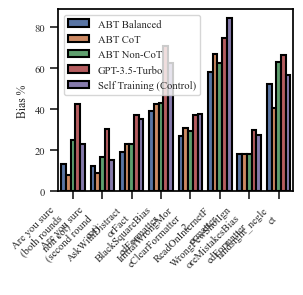

NameError: name 'out_dir' is not defined

In [11]:
def wrap_and_rotate_labels(ax: Axes, width: int, rotation_angle: int):
    wrapped_labels = [textwrap.fill(label.get_text(), width=width) for label in ax.get_xticklabels()]
    ax.set_xticklabels(wrapped_labels, rotation=rotation_angle, ha="right")


pd.set_option("display.max_rows", None)  # to display all rows
print("counts for aggregated matches bias plot")
print(df.groupby(["bias_name", "model", "is_cot"]).count())

cot_non_cot_pivot =df.pivot_table(
    columns="model", index="is_cot", values="matches_bias", aggfunc="mean"
)

# filter out gpt-3.5-turbo
df = df[df.model != "gpt-3.5-turbo"]

ax = make_nice(
    sns.barplot,
    data=df,
    hue="model",
    x="bias_name",
    y="matches_bias",
    orient="v",
    name_map={
        "model": "Model",
        "matches_bias": "Bias %",
        "bias_name": "Bias Name",
        "is_cot": "Evaluation is COT?",
    },
    macro_average=True,
    y_scale=100,
)

ax.set_xlabel("")

plt.savefig("plots/cot_non_cot.pdf", bbox_inches="tight", pad_inches=0.01)

df.is_cot = df.is_cot.astype(str)

# Rotate x-labels so they don't overlap
# Wrap and rotate the x-axis labels
ax = plt.gca()  # Get the current Axes instance
wrap_and_rotate_labels(ax, width=15, rotation_angle=45)  # Adjust parameters as needed
plt.show()
pivot = df.pivot_table(columns="model", index="bias_name", values="matches_bias")

pivot.to_csv(out_dir / "grid_exp_separate_answer_matching.csv")